# **Team Project - Digit Recognizer - Group 11** 
Learn computer vision fundamentals with the famous MNIST data

Due by 11:59pm, Sunday, May 8, 2022

You are doing live competition at: https://www.kaggle.com/competitions/digit-recognizer (Links to an external site.)
* Sign up your individual account on Kaggle, and form a team of no more than four students.
* There should not be any non-active BUDT 737 students in your team.
* Study the Overview in details: Description, Tutorial, Evaluation, and Frequently Asked Questions.
* Read the Data Description in details, then use the Kaggle API to download the dataset.
* You may participate in the Discussion.
* Monitor your team standing and score on the Leaderboard.
* You have to read, accept and follow the Rules.

Submission on ELMS:

* a budt737_spring22_##.ipynb file, including comments and text explanations
* a budt737_spring22_##.docx including but not limited to:
> * the account names and the team name on the Kaggle.com 
> * methods used results and reports
> * what did you do and what have you learned



## Modules and Libraries Import

In [ ]:
# import needed libraries and modules 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
import torch
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from ipywidgets import interact, widgets
from google.colab import drive

In [ ]:
# train model on a hardware accelerator like the GPU if it is available, since this project is really GPU consuming.
for index in range(torch.cuda.device_count()):
  print(torch.cuda.get_device_properties(index))

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


## Data pre-processing on visualization and modeling

In [ ]:
# get access to the google drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# download data from kaggle and read it from google drive 
train = pd.read_csv('/content/gdrive/My Drive/train.csv')
test = pd.read_csv('/content/gdrive/My Drive/test.csv')

In [ ]:
# change the data type to unit8
train = train.astype(np.uint8)

In [ ]:
# separate the train data to image and label 
X = train.drop(columns=['label'])      
y = train['label']                     

In [ ]:
# normalize the values to range from 0 to 1 to make the computation become easier and faster.
X = X / 255.0
test = test / 255.0

In [ ]:
# split the data from training set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0, stratify = y)

In [ ]:
# define the data set used for visualizing and modeling
X_train_visualize = X_train.values.reshape(X_train.shape[0], 28, 28)
X_train_model = X_train.values.reshape(-1,28,28,1)
X_test_visualize = X_test.values.reshape(X_test.shape[0], 28, 28)
X_test_model = X_test.values.reshape(-1,28,28,1)
y_train_model = keras.utils.to_categorical(y_train, num_classes = 10,dtype='uint8')
y_test_model = keras.utils.to_categorical(y_test, num_classes = 10,dtype='uint8')
test = test.values.reshape(-1,28,28,1)

## Visualization on training data set

How many rows of train images you want to review?5


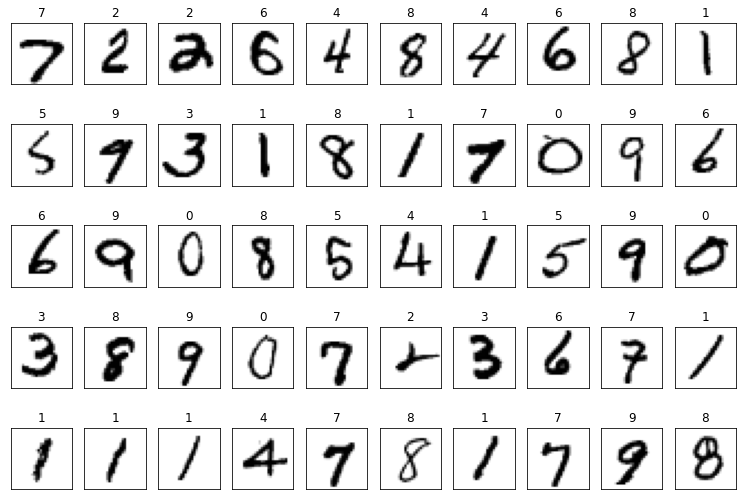

In [ ]:
# define the class name from 0-9
class_names = {index:cn for index, cn in enumerate(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])}
# define the visualizaiton plot on training data set 
def plot(images, labels, predictions=None):
    # create a grid with 10 columns
    n_cols = min(10, len(images))
    n_rows = math.ceil(len(images) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols + 3, (n_rows*2) - 1))
    if predictions is None:
        predictions = [None] * len(labels)
    for index, (x, y_true, y_pred) in enumerate(zip(images, labels, predictions)):
        ax = axes.flat[index]
        ax.imshow(x, cmap=plt.cm.binary)
        ax.set_title(class_names[y_true])
        if y_pred is not None:
            ax.set_xlabel(class_names[y_pred])
        ax.set_xticks([])
        ax.set_yticks([])

# ask user how many rows of images they want to review and plot it
rows_train_images = int(input('How many rows of train images you want to review?'))
plot(X_train_visualize[:rows_train_images * 10], y_train[:rows_train_images * 10])

## Define the CNN model and start training

In [ ]:
# check the length of each data set used for modeling
len(X_train_model),len(X_test_model),len(y_train_model),len(y_test_model)

(33600, 8400, 33600, 8400)

In [ ]:
# define the CNN model
def cnn_model():
    model = Sequential()
    
    model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
    model.add(BatchNormalization())

    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same',  activation ='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(10, activation = "softmax"))
    
    # Define Optimizer
    optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
        
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


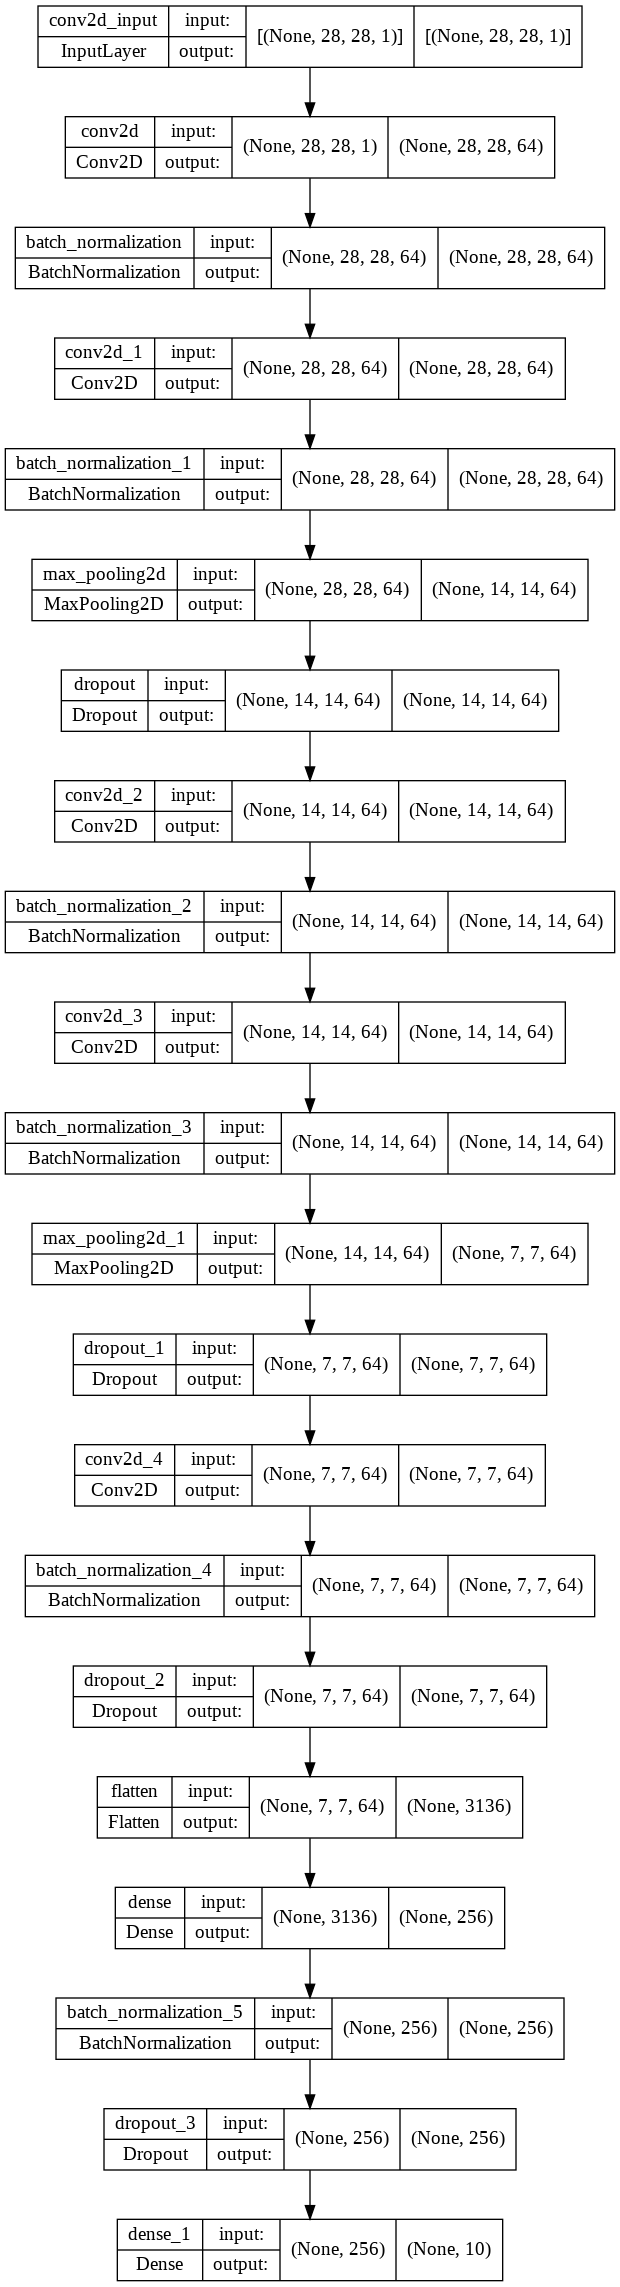

In [ ]:
# visualize the model structure 
model_visualize = cnn_model()
plot_model(model_visualize, to_file='model.png', show_shapes=True)
Image("model.png")

In [ ]:
# create five CNN models 
nets = 5
model = [0] * nets

for j in range(nets):
    model[j] = cnn_model()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
# define callbacks : Reduce learning rate 
callbacks = [
    ReduceLROnPlateau(monitor='val_accuracy', 
                      patience=5, 
                      verbose=1, 
                      factor=0.6, 
                      min_lr=0.000001),    
]

In [ ]:
# define method of data augmentation and fit in to the train model data set 
datagen = keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False, # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(X_train_model)

In [ ]:
# define batch size and epochs 
batch_size = 128
epochs = 50

#train the model and print the maximum training and validation accuracy in history
history = [0] * nets
for j in range(nets):
  history[j] = model[j].fit_generator(datagen.flow(X_train_model,y_train_model, batch_size=batch_size),
                              shuffle = True, epochs = epochs, validation_data = (X_test_model,y_test_model),
                              verbose = 2, steps_per_epoch=X_train_model.shape[0] // batch_size,
                              callbacks = callbacks)
  print("[CNN {0:d}]: Epochs={1:d}, Train Accuracy={2:.5f}, Validation Accuracy={3:.5f}".format(
      j+1,epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy'])))

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


262/262 - 22s - loss: 0.2752 - accuracy: 0.9147 - val_loss: 7.2701 - val_accuracy: 0.1240 - lr: 0.0010 - 22s/epoch - 84ms/step
Epoch 2/50
262/262 - 11s - loss: 0.0889 - accuracy: 0.9725 - val_loss: 0.1611 - val_accuracy: 0.9493 - lr: 0.0010 - 11s/epoch - 43ms/step
Epoch 3/50
262/262 - 10s - loss: 0.0624 - accuracy: 0.9803 - val_loss: 0.0429 - val_accuracy: 0.9880 - lr: 0.0010 - 10s/epoch - 40ms/step
Epoch 4/50
262/262 - 10s - loss: 0.0526 - accuracy: 0.9839 - val_loss: 0.0415 - val_accuracy: 0.9893 - lr: 0.0010 - 10s/epoch - 40ms/step
Epoch 5/50
262/262 - 10s - loss: 0.0447 - accuracy: 0.9862 - val_loss: 0.0374 - val_accuracy: 0.9892 - lr: 0.0010 - 10s/epoch - 39ms/step
Epoch 6/50
262/262 - 10s - loss: 0.0401 - accuracy: 0.9884 - val_loss: 0.0371 - val_accuracy: 0.9915 - lr: 0.0010 - 10s/epoch - 36ms/step
Epoch 7/50
262/262 - 10s - loss: 0.0399 - accuracy: 0.9876 - val_loss: 0.0498 - val_accuracy: 0.9846 - lr: 0.0010 - 10s/epoch - 39ms/step
Epoch 8/50
262/262 - 10s - loss: 0.0342 - acc

## Visualization on the validation data set

In [ ]:
# predict on the validation data set
probs = model[1].predict(X_test_model)
preds = model[1].predict(X_test_model).argsort()[:,-1]
print(preds)

[4 8 5 ... 1 3 1]


In [ ]:
# visualize the prediction result with an interactive widgets
img_idx_slider = widgets.IntSlider(value=0, min=0, max=len(X_test) - 1, description="Image index", layout=widgets.Layout(width='50%'))
@interact(index=img_idx_slider)
def visualize_prediction(index=0):
    fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(X_test_visualize[index], cmap=plt.cm.binary)
    ax1.set_title("label: %s" % class_names[np.array(y_test)[index]])
    ax1.set_xlabel("predict: %s" % class_names[preds[index]])
    ax1.set_ylabel("pixel location")
    ax1.xaxis.tick_top()
    ax2.bar(x=[class_names[index] for index in range(10)], height=probs[index]*100, color = "lightblue")
    ax2.set_xlabel("predict")
    ax2.set_ylabel("probability in %")
    ax2.set_ylim([0, 100])

interactive(children=(IntSlider(value=0, description='Image index', layout=Layout(width='50%'), max=8399), Out…

## Predict on the test data set to be ready for submission

In [ ]:
# Ensemble results 
results = np.zeros((test.shape[0],10)) 

for j in range(nets):
    results = results + model[j].predict(test)


results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")

In [ ]:
# Create submission file ready for submit
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("/content/gdrive/My Drive/submission.csv",index=False)